In [ ]:
import pandas as pd
import numpy as np
import torch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as data_utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
train_data = data_utils.MNIST(root='./data', train=True, download=True)
test_data = data_utils.MNIST(root='./data', train=False, download=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_image(image):
    n_images = len(image)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image[i],cmap='bone')
        ax.axis('off')

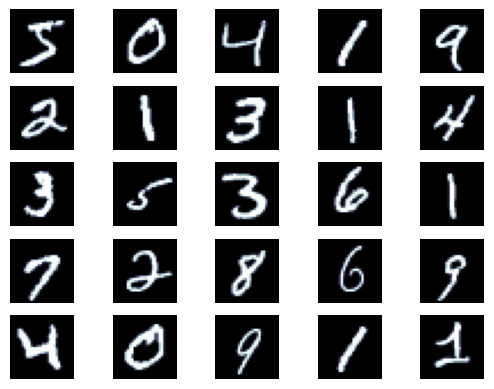

In [ ]:
N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_image(images)

In [ ]:
VALID_RADIO = 0.9
n_train_samples = int(len(train_data) * VALID_RADIO)
n_valid_samples = len(train_data) - n_train_samples

In [ ]:
import torch.utils.data as data

In [ ]:
train_data, valid_data = data.random_split(train_data, [n_train_samples, n_valid_samples])

In [ ]:
len(train_data), len(valid_data)

(54000, 6000)

In [ ]:
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255
mean, std

(tensor(0.1307), tensor(0.3081))

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, [std])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, [std])
])

In [ ]:
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

In [ ]:
BATCH_SIZE = 256
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
len(train_dataloader), len(valid_dataloader)

(211, 24)

In [ ]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 1, 28, 28])

In [ ]:
input, label = next(iter(train_dataloader))

In [ ]:
class LeNetClassifier(nn.Module):
  def __init__(self,num_classes):
    super(LeNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,padding="same")
    self.avgpool1 = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.avgpool2 = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(in_features=120, out_features=84)
    self.linear3 = nn.Linear(in_features=84, out_features=num_classes)

    nn.init.kaiming_normal_(self.linear1.weight,nonlinearity='relu')
    nn.init.kaiming_normal_(self.linear2.weight,nonlinearity='relu')
    nn.init.kaiming_normal_(self.linear3.weight,nonlinearity='relu')
  def forward(self, input):
    output = self.conv1(input)
    output = F.relu(self.avgpool1(output))

    output = self.conv2(output)
    output = F.relu(self.avgpool2(output))

    output = self.flatten(output)
    output = self.relu(self.linear1(output))
    output = self.relu(self.linear2(output))
    output = self.linear3(output)

    return output

In [ ]:
num_classes = len(train_data.dataset.classes)
num_classes

10

In [ ]:
lenet = LeNetClassifier(num_classes)
lenet

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
from torchsummary import summary
summary(lenet, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
              ReLU-7                  [-1, 120]               0
            Linear-8                   [-1, 84]          10,164
              ReLU-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.24
Estimated Tot

In [ ]:
predictions = lenet(input)
predictions.shape

torch.Size([256, 10])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
loss = criterion(predictions, label)
loss

tensor(2.3156, grad_fn=<NllLossBackward0>)

In [ ]:
lenet.to(device)

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import time

In [ ]:
def train(model,optimizer,criterion,train_dataloader,device,epoch=0,log_interval=50):
  model.train()
  total_acc, total_count = 0,0
  losses = []
  start_time = time.time()
  for idx, (input, label) in enumerate(train_dataloader):
    input, label = input.to(device), label.to(device)

    optimizer.zero_grad()

    predictions = model(input)

    loss = criterion(predictions, label)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    total_acc += (predictions.argmax(dim=1) == label).sum().item()
    total_count += label.size(0)
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches '
            '| accuracy {:8.3f} | loss {:8.3f} |'.format(
                epoch, idx, len(train_dataloader),
                total_acc/total_count, loss))
      total_acc, total_count = 0.0, 0
      start_time = time.time()
  epoch_acc = total_acc/total_count
  epoch_loss = sum(losses)/len(losses)
  return epoch_acc, epoch_loss

In [ ]:
train_acc, train_loss = train(lenet,optimizer,criterion,train_dataloader,device)

| epoch   0 |    50/  211 batches | accuracy    0.655 | loss    0.391 |
| epoch   0 |   100/  211 batches | accuracy    0.895 | loss    0.335 |
| epoch   0 |   150/  211 batches | accuracy    0.925 | loss    0.236 |
| epoch   0 |   200/  211 batches | accuracy    0.938 | loss    0.140 |


In [ ]:
def evaluate(model,criterion,valid_dataloader):
  model.eval()
  total_acc,total_count = 0,0
  losses = []
  with torch.no_grad():
    for idx, (input, label) in enumerate(valid_dataloader):
      input, label = input.to(device), label.to(device)
      predictions = model(input)
      loss = criterion(predictions, label)
      losses.append(loss.item())
      total_acc += (predictions.argmax(dim=1) == label).sum().item()
      total_count += label.size(0)
  epoch_acc = total_acc/total_count
  epoch_loss = sum(losses)/len(losses)
  return epoch_acc, epoch_loss

In [ ]:
eval_acc, eval_loss = evaluate(lenet,criterion,valid_dataloader)
eval_acc, eval_loss

(0.961, 0.140922867693007)

In [ ]:
num_classes = len(train_data.dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lenet_model = LeNetClassifier(num_classes).to(device)
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_val = 100

for epoch in range(1,num_epochs+1):
  epoch_start_time = time.time()

  train_acc, train_loss = train(lenet_model,optimizer,criterion,train_dataloader,device,epoch)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  eval_acc, eval_loss = evaluate(lenet_model,criterion,valid_dataloader)
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)

  if eval_loss < best_loss_val:
    best_loss_val = eval_loss
    torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')
  print('-' * 59)
  print('| end of epoch {:3d} | time: {:5.2f}s | '
        'train accuracy {:8.3f} | train loss {:8.3f} | '
        'valid accuracy {:8.3f} | valid loss {:8.3f} |'.format(
            epoch, time.time() - epoch_start_time,
            train_acc, train_loss, eval_acc, eval_loss))
  print('-' * 59)
lenet_model.load_state_dict(torch.load(save_model+'/lenet_model.pt'))
lenet_model.eval()




| epoch   1 |    50/  211 batches | accuracy    0.710 | loss    0.314 |
| epoch   1 |   100/  211 batches | accuracy    0.897 | loss    0.315 |
| epoch   1 |   150/  211 batches | accuracy    0.932 | loss    0.151 |
| epoch   1 |   200/  211 batches | accuracy    0.947 | loss    0.202 |
-----------------------------------------------------------
| end of epoch   1 | time: 28.99s | train accuracy    0.951 | train loss    0.438 | valid accuracy    0.958 | valid loss    0.146 |
-----------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.961 | loss    0.123 |
| epoch   2 |   100/  211 batches | accuracy    0.962 | loss    0.090 |
| epoch   2 |   150/  211 batches | accuracy    0.962 | loss    0.088 |
| epoch   2 |   200/  211 batches | accuracy    0.969 | loss    0.098 |
-----------------------------------------------------------
| end of epoch   2 | time: 29.51s | train accuracy    0.974 | train loss    0.116 | valid accuracy    0.970 | va

<ipython-input-67-ccaed3f94bad>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model+'/lenet_model.pt'))


LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)

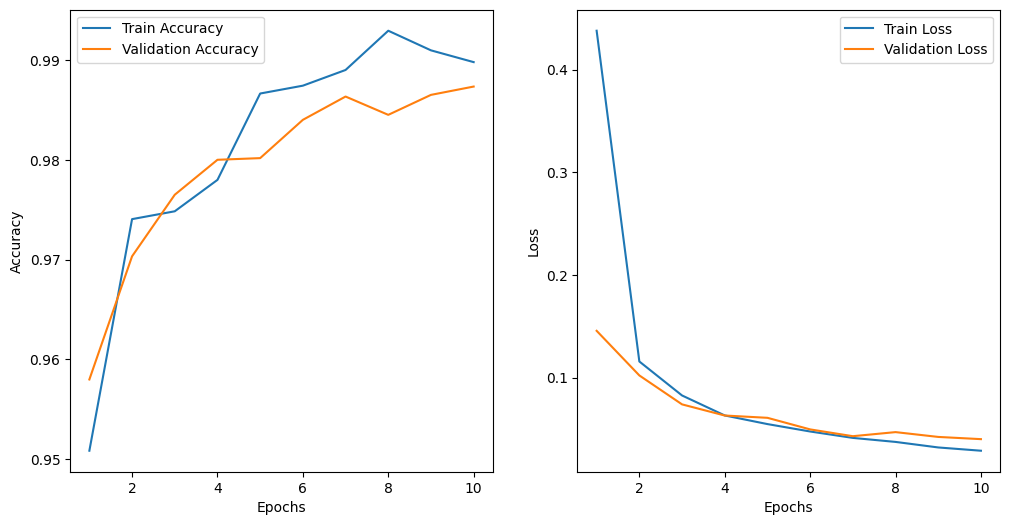

In [ ]:
def plot_results(num_epochs,train_accs,train_losses,eval_accs,eval_losses):
  epochs = list(range(1,num_epochs+1))
  fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
  axs[0].plot(epochs,train_accs,label='Train Accuracy')
  axs[0].plot(epochs,eval_accs,label='Validation Accuracy')
  axs[1].plot(epochs,train_losses,label='Train Loss')
  axs[1].plot(epochs,eval_losses,label='Validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss')
  axs[0].legend()
  axs[1].legend()
plot_results(num_epochs,train_accs,train_losses,eval_accs,eval_losses)

In [ ]:
test_data.transform = test_transforms
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_acc, test_loss = evaluate(lenet_model,criterion,test_dataloader)
test_acc, test_loss

(0.9869, 0.037836189393419775)

In [ ]:
def plot_filtered_images(images,filters):
  images = torch.cat([image.unsqueeze(0) for image in images],dim=0).cpu()
  filters = filters.cpu()
  n_images = images.shape[0]
  n_filters = filters.shape[0]

  filtered_images = F.conv2d(images,filters)
  fig = plt.figure(figsize=(20,10))

  for i in range(n_images):
    ax = fig.add_subplot(n_images,n_filters+1,i+1+(i*n_filters))
    ax.imshow(images[i].squeeze(0),cmap='bone')
    ax.set_title('Original Image')
    ax.axis('off')

    for j in range(n_filters):
      image = filtered_images[i][j]
      ax = fig.add_subplot(n_images,n_filters+1,i+1+(i*n_filters)+1+j)
      ax.imshow(image.numpy(),cmap='bone')
      ax.set_title(f'Filter {j+1}')
      ax.axis('off')

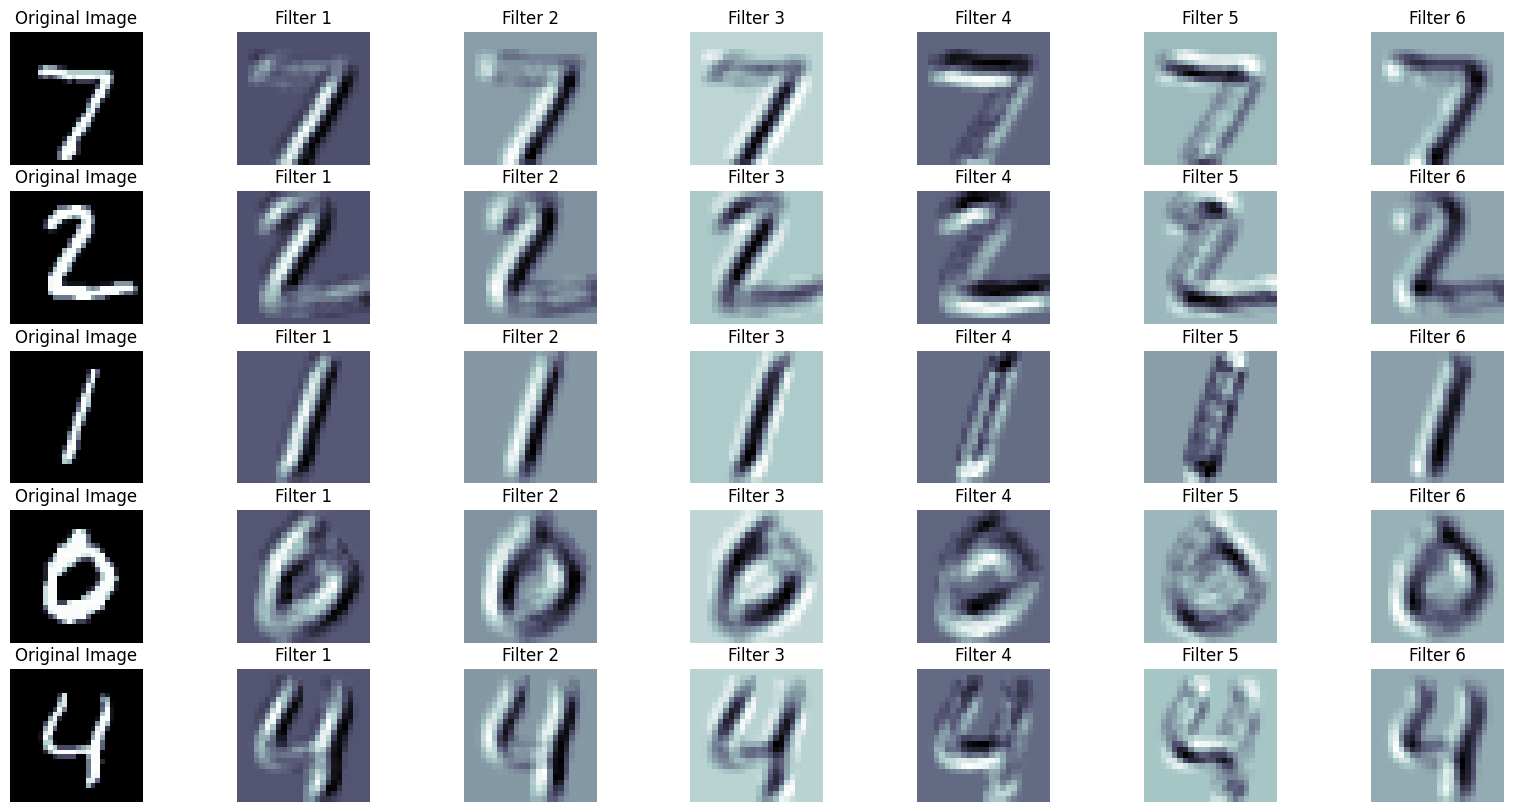

In [ ]:
N_IMAGES = 5
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = lenet_model.conv1.weight.data
plot_filtered_images(images,filters)

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O /content/cassavaleafdata.zip

--2024-10-15 05:16:36--  https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354096203 (1.3G) [application/octet-stream]
Saving to: ‘cassavaleafdata.zip’

cassavaleafdata.zip 100%[===================>]   1.26G  30.7MB/s    in 44s     

2024-10-15 05:17:21 (29.6 MB/s) - ‘cassavaleafdata.zip’ saved [1354096203/1354096203]



In [ ]:
!unzip /content/cassavaleafdata.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
 

In [ ]:
%cd /content/cassavaleafdata

/content/cassavaleafdata


In [ ]:
data_paths = {
    'train' : './train',
    'test' : './test',
    'valid':'./validation'
}

In [ ]:
import os

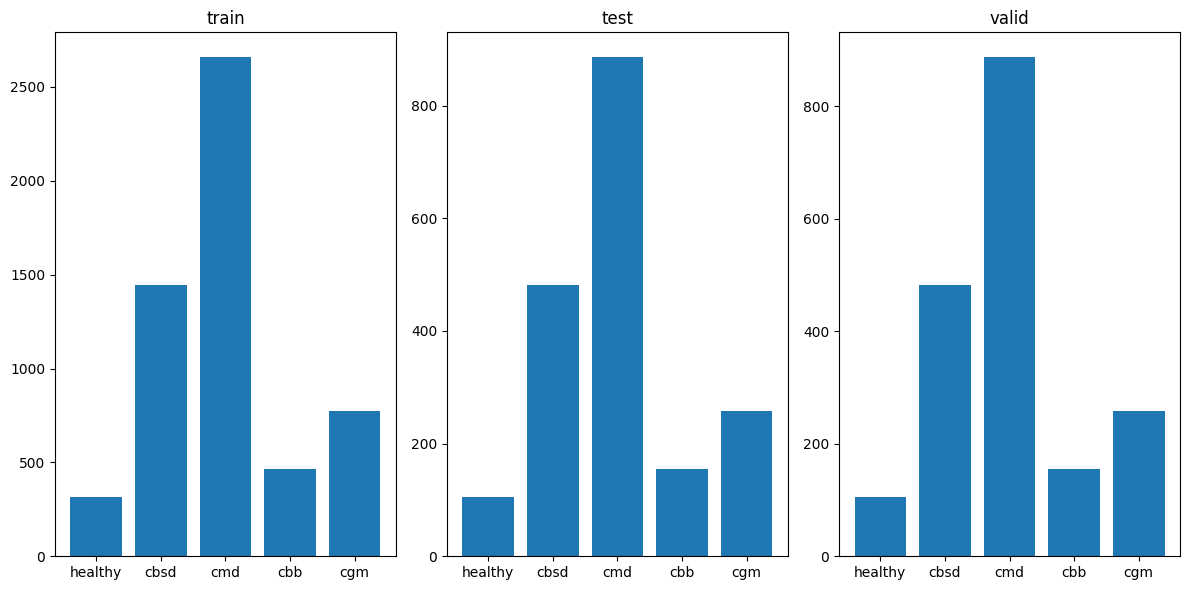

In [ ]:
from imutils import paths
def show_label(data_paths):
  fig, ax  = plt.subplots(1,len(data_paths),figsize=(12,6))
  for idx, (key,sub_dir) in enumerate(data_paths.items()):
    labels = os.listdir(sub_dir)
    list_data = []
    for label in labels:
      image_files = list(paths.list_images(os.path.join(sub_dir,label)))
      list_data.append(len(image_files))
    ax[idx].bar(labels,list_data)
    ax[idx].set_title(f'{key}')
  plt.tight_layout()
  plt.show()
show_label(data_paths)

In [ ]:
labels_dict = {
    "cbb":"Cassava Bacterial Blight",
    "cbsd":"Cassava Brown Streak Disease",
    "cgm":"Cassava Green Mottle",
    "cmd":"Cassava Mosaic Disease",
    "healthy":"Healthy"
}

In [ ]:
def plot_images(data_dir,label,num_sample=6):
  data_dir = os.path.join(data_dir,label)
  image_files = list(paths.list_images(data_dir))[:num_sample]
  fig, ax = plt.subplots(2,num_sample//2,figsize=(12,6))
  for i, image_file in enumerate(image_files):
    image = Image.open(image_file)
    label = image_file.split('/')[-2]
    ax[i//(num_sample//2),i%(num_sample//2)].imshow(image)
    ax[i//(num_sample//2),i%(num_sample//2)].set_title(f'{labels_dict[label]}')
    ax[i//(num_sample//2),i%(num_sample//2)].axis('off')
  plt.tight_layout()
  plt.show()

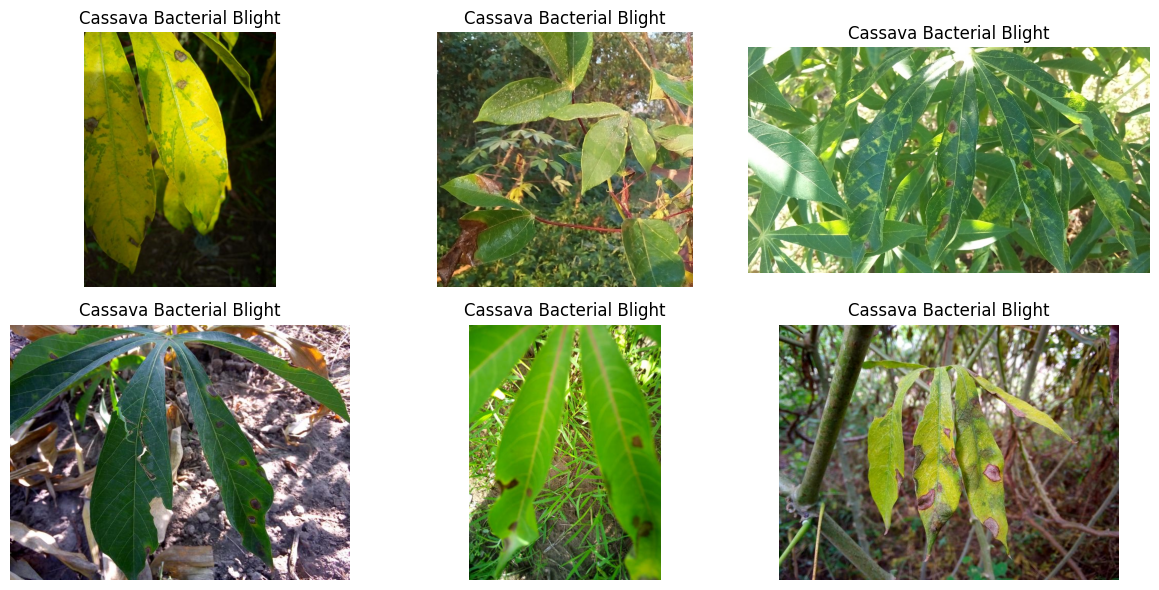

In [ ]:
plot_images(data_paths['train'],'cbb')

In [ ]:
def loader(path):
  return Image.open(path)

In [ ]:
img_size = 150
transformer = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
])
#

In [ ]:
train_dataset = data_utils.ImageFolder(root=data_paths['train'],transform=transformer,loader=loader)
test_dataset = data_utils.ImageFolder(root=data_paths['test'],transform=transformer,loader=loader)
valid_dataset = data_utils.ImageFolder(root=data_paths['valid'],transform=transformer,loader=loader)

In [ ]:
BATCH_SIZE = 512
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class LeNetClassifierCassava(nn.Module):
  def __init__(self,num_classes):
    super(LeNetClassifierCassava, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1,padding="same") # 150 x 150
    self.avgpool1 = nn.AvgPool2d(kernel_size=2) # 6 x 75 x 75
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # 16 x 71 x 71
    self.avgpool2 = nn.AvgPool2d(kernel_size=2) # 16 x 35 x 35
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=35*35*16, out_features=120)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(in_features=120, out_features=84)
    self.linear3 = nn.Linear(in_features=84, out_features=num_classes)

    nn.init.kaiming_normal_(self.linear1.weight,nonlinearity='relu')
    nn.init.kaiming_normal_(self.linear2.weight,nonlinearity='relu')
    nn.init.kaiming_normal_(self.linear3.weight,nonlinearity='relu')
  def forward(self, input):
    output = self.conv1(input)
    output = F.relu(self.avgpool1(output))

    output = self.conv2(output)
    output = F.relu(self.avgpool2(output))

    output = self.flatten(output)
    output = self.relu(self.linear1(output))
    output = self.relu(self.linear2(output))
    output = self.linear3(output)

    return output

In [ ]:
num_classes = len(train_dataset.classes)
num_classes

5

In [ ]:
cassav = LeNetClassifierCassava(num_classes)
cassav

LeNetClassifierCassava(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=19600, out_features=120, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=5, bias=True)
)

In [ ]:
summary(cassav, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 150, 150]             456
         AvgPool2d-2            [-1, 6, 75, 75]               0
            Conv2d-3           [-1, 16, 71, 71]           2,416
         AvgPool2d-4           [-1, 16, 35, 35]               0
           Flatten-5                [-1, 19600]               0
            Linear-6                  [-1, 120]       2,352,120
              ReLU-7                  [-1, 120]               0
            Linear-8                   [-1, 84]          10,164
              ReLU-9                   [-1, 84]               0
           Linear-10                    [-1, 5]             425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 2.21
Params size (MB): 9.02
Estimat